In [1]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display as li
import mido
from mido import MidiFile
import glob
import nbimporter
import Preprocess
import librosa as li
np.set_printoptions(threshold=np.nan) # print shows all.
pretty_midi.pretty_midi.MAX_TICK = 1e30 # Prevents Maximum tick overflow for the midi tracks that are big (normal songs).

Importing Jupyter notebook from Preprocess.ipynb


In [2]:
''' Plot the midi file in 2D.
    A pretty_midi file object is required (pm).
    Start and end pitch, are reffering to which radius the image should
    plot. Librosa is required to run this function.
'''
inputfile = 'G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\Music Dataset\Validation Dataset\MAPS_SptkBGAm_2\SptkBGAm\MUS\MAPS_MUS-alb_esp2_SptkBGAm.mid'
def plot_piano_roll(pm, start_pitch=21, end_pitch=108, fs=100):
    plt.figure()
    # Use librosa's specshow function for displaying the piano roll
    midifile = pretty_midi.PrettyMIDI(pm)
    li.display.specshow(midifile.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [3]:
''' Get relation between midi vocabulary and Hertz Frequencies.
    128 possible notes in midi representation.
'''

def midi_hertz():
    g = 2**(1/12)
    f = lambda midipitch: 440*g**(midipitch-69)
    relation = np.zeros(128*2).reshape(128,2)
    for midi in range(128):
        freq = f(midi)
        relation[midi,0] = int(midi)
        relation[midi,1] = freq
        #print('midi = {} = {:.1f} Hz'.format(midi, freq))
    #return relation
midi_hertz()

In [4]:
''' Get a path as an input. This path must point on a midi file.
    This is a Parser using mido library, parsing the messages it creates.
    Format of messages : "note_on channel=0 note=99 velocity=37 time=14913"
    We clean the messages and keep only the information of the midi.
    We parse it and then store each feature to their respective arrays,
    which we turn them into numpy ones at the end of the function.
    It returns : 
    Onsets (Perfectly done)
    Offsets (Kicks error if data is not cleaned)
    Notes (Kicks error if data is not cleaned)
'''
def midi_data_extractor(path):
# Inputs of function:
    prettyfile = pretty_midi.PrettyMIDI(path)
    midi_file = MidiFile(path)
    # Onsets, length of the midi file:   
    onsets = prettyfile.get_onsets()
    length = prettyfile.get_end_time() # length of midi track.
# Get Data:
    msgs = []   # msgs are the data we need in the message format of mido.
    midi_notes = []
    for i, track in enumerate(midi_file.tracks):
        for message in track:
            msgs.append(message)
            midi_notes.append(message.bytes()) # to get notes!
# Clean Data:
    if str(msgs[0]).startswith('<meta message'):
        start_message, end_message = msgs[0], msgs[-1]
        start_message = str(start_message).split(' ')
    # end_message = str(end_message).split(' ') It is not needed at all.
        tempo = start_message[3].rsplit('=', 2)[-1]
        del midi_notes[0], midi_notes[-1]
        del msgs[0], msgs[-1]
    # Remove information about "message control_change" if there is:
# Extract the data and numpy them.
# Initialize : 
    on_offs = [None]*len(msgs)
    channels = [None]*len(msgs)
    velocities = [None]*len(msgs)
    time = [None]*len(msgs)
    spliter = [None]*5
    for msg in range(len(msgs)):
        spliter = str(msgs[msg]).split(' ')
# Parse Data:
        if spliter[0].startswith('note_off'):
            on_offs[msg] = 0
        elif spliter[0].startswith('note_on'):
            on_offs[msg] = 1
            
        channels[msg] = int(list(filter(str.isdigit, spliter[1]))[0])
       
        if spliter[3].startswith('velocity='):
            velocities[msg] = spliter[3].rsplit('=', 1)[-1]
            
        if spliter[-1].startswith('time='):
            time[msg] = spliter[-1].rsplit('=', 1)[-1]
# These are the extracted information from the midi file, but they are Strings!
# Convert lists to numpy arrays:
    on_offs = np.asarray(on_offs, dtype=np.bool_) # np.float = np.float64 = python's float.
    channels = np.asarray(channels, dtype=np.int8)
    #velocities = np.asarray(velocities, dtype=np.int16)
    time = np.asarray(time, dtype=np.float64)
    tempo = np.asarray(tempo, dtype=np.int)
    onsets = np.asarray(onsets, dtype=np.float64)
    
# For offsets, use the sum of previous to get offset times (according to dataset).
    time = mido.tick2second(time, midi_file.ticks_per_beat, tempo)
    offsets = np.zeros(int(len(time)/2))
    # Get correct time format, by summing subsecutive timestamps of midi info
    for x in range(len(offsets)):
        offsets[x] = time[x] + time[x+1] + offsets[x-1]
    print ('There are {} instruments'.format(len(prettyfile.instruments)))
    print ('Instrument 1 has {} notes'.format(len(prettyfile.instruments[0].notes)))        
    
# Getting notes!
    notes = []
    for i in range(len(midi_notes)):
        notes.append(midi_notes[i][1])
    notes = np.asarray(notes, dtype=np.int8)
    return onsets, offsets, notes, on_offs

In [5]:
'''Compute and return the midi onsets of the file loaded.'''
def midi_onsets(path):
    prettyfile = pretty_midi.PrettyMIDI(path)
    onsets = prettyfile.get_onsets()
    return onsets

In [6]:
''' If the tempo changes, we get a message from mido about "message control_change".
    Must fix !
'''
#offsets, notes, 
#onsets

' If the tempo changes, we get a message from mido about "message control_change".\n    Must fix !\n'

In [7]:
'''Check in every frame, which note has a value. Put value=1 and go to next
frame. If there is still a note, keep value=1.
When you see a note=0, then put value=0.
Zero pad to reach needed frames frames with 88 filterbanks each.
'''

def piano_roll(midi_path, number_of_frames, start_pitch=21, end_pitch=109):
    '''Need Pretty_midi.
    FPS = 100 as the Paper suggested.
    We get the path, and then load with pretty_midi the file.
    We need to put limits to which notes we are getting. We do not need all 127 notes of piano roll.
    We need 88 notes only. Spontaneously [21-108] midi notes.
    We transpose the midi piano roll, as we need same dimension with the filterbanks of the wave file.
    We then check, wherever there is a note (that is telling us which banks and which frame hits a note), we 
    change the value to 1. Now, we zero pad to reach the same dimensions as on fbanks => 2000 frames with 88 banks each.
    '''
   
    midifile = pretty_midi.PrettyMIDI(midi_path)
    midi_data_labels = midifile.get_piano_roll(100)[start_pitch:end_pitch]
    midi_labels = midi_data_labels.transpose()
    #print(midi_labels[round(midi_labels.shape[0]/2)])
    for i in range(midi_labels.shape[0]):
         for j in range(midi_labels.shape[1]):
                if midi_labels[i,j] != 0:
                    midi_labels[i,j] = 1
    
    #Zero Pad to reach filterbanks dimensions, (2000, 88):
    if midi_labels.shape[0] < number_of_frames:
        zeropad = np.zeros((number_of_frames-midi_labels.shape[0], 88))
        #print("Concat: ", midi_labels.shape, zeropad.shape)
        midi_labels = np.concatenate((midi_labels, zeropad))
        #print("shape  midi" ,midi_labels.shape)
    else:
        midi_labels = midi_labels[:,:number_of_frames]
    return midi_labels

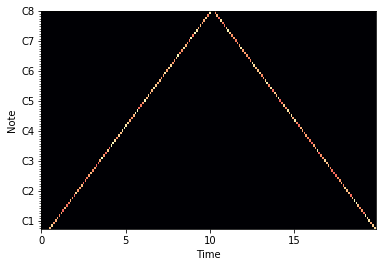

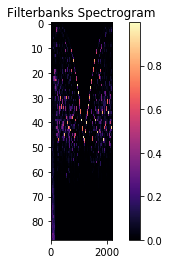

In [13]:
'''
Testing, comparing same files.
Midi Y axis is from low to high
Wave Y axis is from high to low. 
Is this correct?

'''
inputfile = 'G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\Test Dataset\MAPS_AkPnBcht_1\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_F_AkPnBcht.mid'
wavefile = 'G:\ΣΧΟΛΗ p12127\Πτυχιακη\MAPS Dataset\Test Dataset\MAPS_AkPnBcht_1\AkPnBcht\ISOL\CH\MAPS_ISOL_CH0.1_F_AkPnBcht.wav'
pm = pretty_midi.PrettyMIDI(inputfile)
midi_labels = piano_roll(inputfile, 18000)
pm.tick_to_time(18498011)

'''Plot the spectrograms:'''
ylabels = plot_piano_roll(inputfile)
yhat = Preprocess.process(wavefile, True)
Preprocess.wave_plot(np.flipud(yhat.T))

In [9]:
'''Debugging purposes:'''
midifile = pretty_midi.PrettyMIDI(inputfile)
midi_data_labels = midifile.get_piano_roll(100)[21:109]
#midi_labels = midi_data_labels.transpose()
print(midi_labels.shape)
print(midi_labels[400]) # ,31

(18000, 88)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
